In [1]:
import math
import time
import os

from persim import plot_diagrams
from tqdm import tqdm

import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal
import numpy as np
import persim
import pywt
import mne

import tda_utils
import dataset
import utils

from hermite_functions import hermite_functions
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
idx = 25 
data_dir = "/work/thesathlab/nchsdb/"

pt_ids = []
for pt_file in os.listdir(os.path.join(data_dir, "sleep_data")):
    if pt_file.endswith(".edf"):
        pt_ids.append(pt_file.replace(".edf", ""))

pt_id = pt_ids[idx]
print(pt_id)
save_dir = "/work/thesathlab/manjunath.sh/tmp"
loader = dataset.AirflowSignalProcessor(pt_id=pt_id, data_dir="/work/thesathlab/nchsdb/", save_dir=save_dir)

100_23083


In [42]:
raw_edf = mne.io.read_raw_edf(loader.edf_fname, verbose=False)
sfreq = raw_edf.info["sfreq"]

target_intervals = loader.find_target_intervals()
airflow_cache = loader.load_epoch_cache(raw_edf, target_intervals)

data = []
dgms_dict = {
    "irr_sublevel": [],
    "airflow_sublevel": [],
    "airflow_rips": [],
}
count = 0

for idx in tqdm(range(len(airflow_cache)), desc=f"Processing {loader.pt_id}..."):
    data_arr = airflow_cache.get_epoch_sequence(idx, n_epochs=6)
    sqi = utils.calculate_sqi(data_arr, sfreq)

    # Calculate IRR signal
    irr_signal = loader.calc_irr(data_arr.squeeze(), sampling_freq=sfreq)

    # Sublevel set filtration of IRR signal
    sublevel_dgms_irr = loader.sublevel_set_filtration(irr_signal)

    # Airflow rips filtration
    rips_dgms_airflow = loader.rips_filtration(data_arr, sfreq)

    # Airflow sublevel filtration
    sublevel_dgms_airflow = loader.sublevel_set_filtration(data_arr)

    ps_irr = loader.persistence_summary(sublevel_dgms_irr[0])
    hepc_irr = loader.hepc(sublevel_dgms_irr[0])

    hepc_rips_airflow_0 = loader.hepc(rips_dgms_airflow[0])
    ps_rips_airflow_1 = loader.persistence_summary(rips_dgms_airflow[1])

    hepc_sub_airflow_0 = loader.hepc(sublevel_dgms_airflow[0])
    ps_sub_airflow_0 = loader.persistence_summary(sublevel_dgms_airflow[0])

    # Skipping if we have very few points in filtration
    if np.isnan(sublevel_dgms_irr[0]).sum() > 0:
        continue

    count += 1

    if count > 0:
        break

Processing 100_23083...:   0%|          | 0/772 [00:01<?, ?it/s]


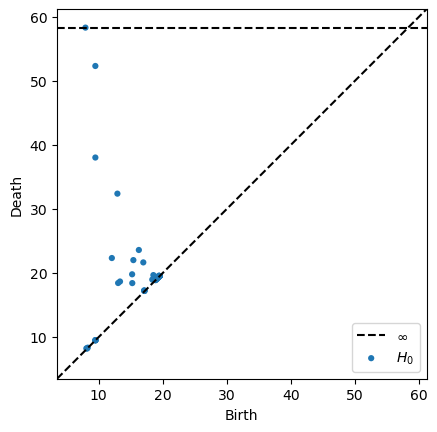

In [81]:
overall_dgms = sublevel_dgms_irr
target_dgm = overall_dgms[0]
dgm_clean = target_dgm[~np.isinf(target_dgm).any(1)]

persim.plot_diagrams(overall_dgms)
plt.show()

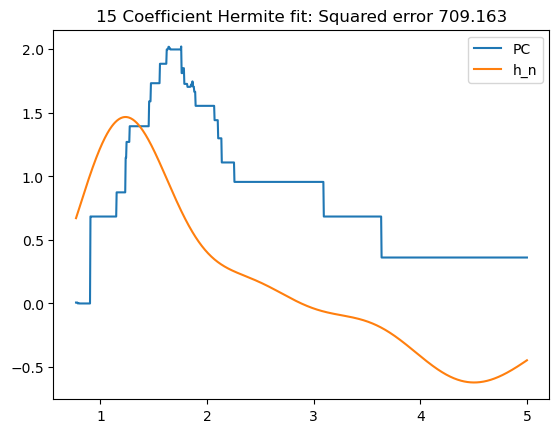

In [84]:
n_coef = 15
# dgm_clean_t = dgm_clean
# dgm_clean_t = dgm_clean - dgm_clean.mean()
dgm_clean_t = dgm_clean * (5 / np.abs(dgm_clean).max())
psi_dgms = tda_utils.psi(dgm_clean_t)
x = np.linspace(dgm_clean_t.min(), dgm_clean_t.max(), 1000)
y = np.zeros(x.shape)

for idx, (b, d) in enumerate(dgm_clean_t):
    arr_idx = (x >= b) & (x <= d)
    y[arr_idx] += psi_dgms[idx]
    
coefs = tda_utils.hepc(dgm_clean_t, n_coef=n_coef)

y_pred = np.zeros(y.shape)
for n, coef in enumerate(coefs):
    hn = hermite_functions(n, x, all_n=False)
    y_pred += coef * hn

plt.figure()
plt.plot(x, y, label="PC")
plt.plot(x, y_pred, label="h_n")
plt.legend()

res_h_n = (y_pred - y) ** 2
plt.title(f"{n_coef} Coefficient Hermite fit: Squared error {res_h_n.sum():.3f}")
plt.show()

100%|██████████| 14/14 [00:00<00:00, 4609.13it/s]


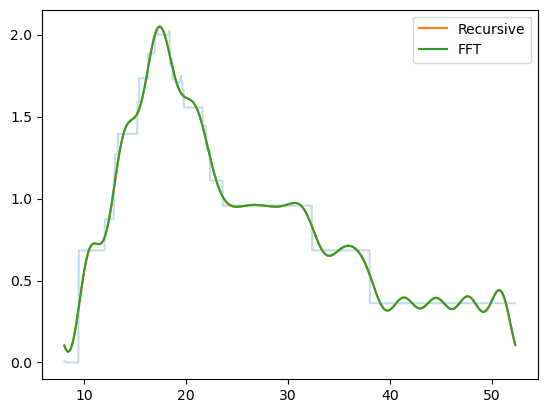

In [83]:
psi_dgms = tda_utils.psi(dgm_clean)
x = np.linspace(dgm_clean.min(), dgm_clean.max(), 1000) 
y = np.zeros(x.shape)

for idx, (b, d) in enumerate(dgm_clean):
    arr_idx = (x >= b) & (x <= d)
    y[arr_idx] += psi_dgms[idx]

coef = np.fft.rfft(y)
coef_app = coef[:15]
approx = np.fft.irfft(coef_app, n=y.shape[0])

# L = max(dgm_clean.max(), np.abs(dgm_clean.min()))
L = dgm_clean.max() - dgm_clean.min()
b = dgm_clean[:, 0]
d = dgm_clean[:, 1]
beta = []

# L = dgm_clean.max()
# beta.append(np.sum(psi_dgms * (d - b)) / L)
# for n in tqdm(range(1, 15)):
#     diff = np.exp(2 * 1.0j * np.pi * b * n / L) - np.exp(2 * 1.0j * np.pi * d * n / L)
#     val = diff * 1.0j * L / (2 * np.pi * n)
#     beta.append(np.sum(psi_dgms * val) / L)
beta.append(2 * np.sum(psi_dgms * (d - b)) / L)
for n in tqdm(range(1, 15)):
    diff = np.exp(2 * 1.0j * np.pi * b * n / L) - np.exp(2 * 1.0j * np.pi * d * n / L)
    val = diff * 1.0j * L / (2 * np.pi * n)
    beta.append(2 * np.sum(psi_dgms * val) / L)

beta = np.asarray(beta)
approx_fft = np.fft.irfft(coef_app, n=y.shape[0])

approx_recursive = np.zeros(x.shape)
for n, beta_n in enumerate(beta):
    # approx_recursive += beta_n * np.exp(2 * 1.0j * np.pi * n * x / L) 
    if n == 0:
        approx_recursive += np.real(beta_n) / 2
    else:
        approx_recursive += np.real(beta_n) * np.cos(2 * np.pi * n * x / L) + np.imag(beta_n) * np.sin(2 * np.pi * n * x / L)

plt.figure()
plt.plot(x, y, alpha=0.25)
plt.plot(x, approx_recursive, label="Recursive")
plt.plot(x, approx_fft, label="FFT")
plt.legend()
plt.show()

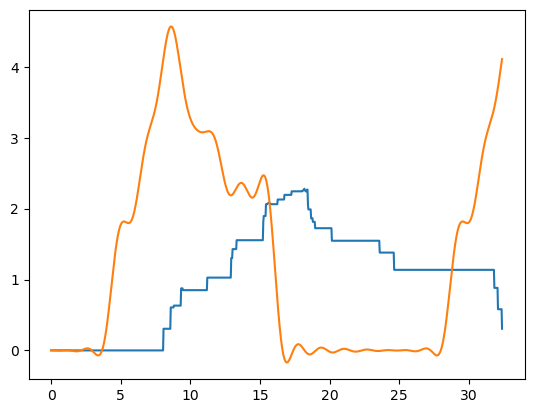

In [39]:
approx_recursive = np.zeros(x.shape)
for n, beta_n in enumerate(beta):
    if n == 0:
        approx_recursive += np.real(beta_n)
    else:
        approx_recursive += 2 * (np.real(beta_n) * np.cos(2 * np.pi * n * x / L) + np.imag(beta_n) * np.sin(2 * np.pi *n *x / L))
    
plt.figure()
plt.plot(x, y)
plt.plot(x, approx_recursive)
plt.show()

In [ ]:
rv = scipy.stats.norm() y_hn = np.zeros(x.shape)
for n, alpha in enumerate(alphan):
    c_n = np.sqrt(2 * np.pi) / np.sqrt(np.power(2, n) * math.factorial(n) * np.sqrt(np.pi))
    phi = rv.pdf(x)
    Hn_val = scipy.special.hermite(n)(x)
    y_hn += alpha * c_n * Hn_val * phi

plt.figure()
plt.plot(x, y)
plt.plot(x, y_hn)
plt.show()

In [ ]:
def phi(x, k, level):
    lo = k / (2 ** level)
    hi = (k+1) / (2 ** level)

    lo_arr = lo <= x
    hi_arr = x <hi 
    val = np.where(lo_arr & hi_arr, 1, 0)
    return val


def int_phi(k, level, b, d):
    if b > d:
        raise RuntimeError("birth cannot be greater than death")
        
    lo = k / (2 ** level)
    hi = (k+1) / (2 ** level)
    # print(b, d, lo, hi)
    
    if (lo <= b < hi) & (lo <= d < hi):
        # print("a")
        return d-b
    elif (b < lo) & (lo <= d < hi):
        # print("b")
        return d - lo
    elif (lo <= b < hi) & (hi < d):
        #print("c")
        return hi - b
    elif (b < lo) & (hi < d):
        # print("d")
        return lo
    # print("e")
    return 0

def phi_parent(x):
    lo_arr = 0 <= x
    hi_arr = x < 1
    val = np.where(lo_arr & hi_arr, 1, 0)
    return val
target_dgm = sublevel_dgms_irr[0]
dgm_clean = target_dgm[~np.isinf(target_dgm).any(1)]
psi_dgms = tda_utils.psi(dgm_clean)

level = 8
x = np.linspace(0, 1, 2 ** level)

alphak = []
for k in tqdm(range((2 ** level) - 1)):
    val = 0
    for idx, (b, d) in enumerate(dgm_clean):
        val += psi_dgms[idx] * int_phi(k, level, b, d)
    alphak.append(val)
alphak = np.asarray(alphak)

# y = np.zeros(x.shape)
# for k, aval in enumerate(alphak):
#     y += aval * phi(x, k, level)
    
print(alphak.shape)
print(alphak[alphak > 0].shape)

In [ ]:
arr = pywt.mra(psi_dgms, "haar", level=8, transform="dwt")

psi_dgms = tda_utils.psi(dgm_clean)
x = np.linspace(0, dgm_clean.max(), 10000) 
y = np.zeros(x.shape)

for idx, (b, d) in enumerate(dgm_clean):
    arr_idx = (x >= b) & (x <= d)
    y[arr_idx] += psi_dgms[idx]
    
plt.figure()
plt.plot(x, y)
plt.show()

print([x.shape for x in arr])

In [ ]:
print(1 / 0.00025)

In [ ]:
coef = scipy.fft.fft(psi_dgms)
pred_arr = scipy.fft.ifft(psi_dgms)

plt.figure()
plt.plot(x, y)
plt.show()

In [ ]:
def h(t):
    if t >= 0 and t <= 0.5:
        return 1
    elif t > 0.5 and t <= 1:
        return -1
    return 0

t = np.linspace(-0.5, 1.5, 1000)


def hnk(t, n, k):
    npow = np.power(2, n)
    val = h((npow * t) - k)
    return val

plt.figure()
[plt.plot(t, [hnk(x, 2, k) for x in t]) for k in range(4)]
plt.show()

In [ ]:
def int_hnk(x, n, k):
    lb = (k-1) / np.power(2, n)
    mb = k / np.power(2, n)
    ub = (k+1) / np.power(2, n)

    if x > lb and x <= mb:
        return (x - lb) / (mb - lb)
    elif x > mb and x < ub:
        val = 1 - (x - mb) / (ub - mb) 
        return val
    return 0

plt.figure()
[plt.plot(t, [int_hnk(x, 2, k) for x in t]) for k in range(4)]
plt.show()

In [ ]:
psi_dgms = tda_utils.psi(dgm_clean)
n = 4
alpha = []

coefs = []
for k in range(np.power(2, n)):
    for idx, (b, d) in enumerate(dgm_clean):
        int_val_d = int_hnk(d, n, k)
        int_val_b = int_hnk(b, n, k)
        val =  psi_dgms[idx] * (int_val_d - int_val_b)
        print(k, idx, b, d, int_val_d, int_val_b, psi_dgms[idx])
        coefs.append(val)


In [ ]:
psi_dgms = tda_utils.psi(dgm_clean)
x = np.linspace(0, dgm_clean.max(), 1000) 
y = np.zeros(x.shape)

for idx, (b, d) in enumerate(dgm_clean):
    arr_idx = (x >= b) & (x <= d)
    y[arr_idx] += psi_dgms[idx]

plt.figure()
plt.plot(np.arange(y.shape[0]), y)
plt.show()

In [ ]:
hepc = loader.hepc(rips_dgms_airflow[0])
print(hepc)